## Self-Check

Detecting Hallucinations in LLM Responses through Log Probabilities

In [1]:
#%sudo apt-get install graphviz

In [2]:
#%pip install --quiet python-graphviz

In [3]:
import os
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv("../keys.env")

assert os.environ["OPENAI_API_KEY"][:2] == "sk", "Please sign up for access to the OpenAI API and provide access token in keys.env file"

In [4]:
# Initialize the client
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

## Logprobs utility functions

In [5]:
from graphviz import Digraph

nodeno = 0
def create_node(graph, label):
    global nodeno
    nodeno = nodeno + 1
    name = f"node_{nodeno}"
    graph.node(name, label)
    return name

def analyze_logprobs(logprobs, verbose: bool = False):
    if not logprobs:
        print("No logprobs available in the response")
        return None

    # create a graph: See https://h1ros.github.io/posts/introduction-to-graphviz-in-jupyter-notebook/
    graph = Digraph("logprobs")
    graph.attr(rankdir="LR")
    graph.format="png"
    graph.node("root", "")
    current_parent = "root"
    
    # Print each token and its probability
    if verbose:
        print("\nToken-by-token analysis:")
        print("-" * 50)
    for token_info in logprobs.content:
        token = token_info.token
        logprob = token_info.logprob
        probability = round(100 * (2.718281828459045 ** logprob), 2)

        if verbose:
            print(f"Token: {token!r}")
            print(f"Log Probability: {logprob:.4f}")
            print(f"Probability: {probability}%")
        
        chosen_node = create_node(graph, f"P({token!r}) = {probability}%")
        graph.edge(current_parent, chosen_node)

        # If top logprobs are available, show alternatives
        if token_info.top_logprobs:
            if verbose:
                print("Top alternatives:")
            for alt_token in token_info.top_logprobs:
                if alt_token.token != token:
                    alt_probability = round(100 * (2.718281828459045 ** alt_token.logprob), 2)
                    if verbose:
                        print(f"  {alt_token.token!r}: {alt_probability}%")
                    alt_node = create_node(graph, f"P({alt_token.token!r}) = {alt_probability}%")
                    graph.edge(current_parent, alt_node)
                    
        if verbose:
            print("-" * 50)
        current_parent = chosen_node # for next iteration
    
    # final graph
    return graph


def analyze_token_confidence(logprobs):
    """Analyze the model's confidence in its predictions"""
    if not logprobs or not hasattr(logprobs, 'content'):
        print("Debug: logprobs structure:", logprobs)  # Debug print
        return

    try:
        confidences = [2.718281828459045 ** lp.logprob for lp in logprobs.content]
        avg_confidence = sum(confidences) / len(confidences)
        min_confidence = min(confidences)
        max_confidence = max(confidences)

        print("\nConfidence Analysis:")
        print(f"Average confidence: {avg_confidence:.2%}")
        print(f"Minimum confidence: {min_confidence:.2%}")
        print(f"Maximum confidence: {max_confidence:.2%}")

        # Find tokens with unusually low confidence
        threshold = avg_confidence * 0.5  # 50% of average confidence
        low_confidence_tokens = [
            (lp.token, 2.718281828459045 ** lp.logprob)
            for lp in logprobs.content
            if 2.718281828459045 ** lp.logprob < threshold
        ]

        if low_confidence_tokens:
            print("\nTokens with unusually low confidence:")
            for token, conf in low_confidence_tokens:
                print(f"Token: {token!r}, Confidence: {conf:.2%}")
    except AttributeError as e:
        print(f"Debug: Error processing logprobs: {e}")
        print(f"Debug: logprobs type: {type(logprobs)}")
        print(f"Debug: logprobs content: {logprobs}")



def calculate_response_confidence(logprobs):
    """Calculate an overall confidence score for the response.
    Returns a score between 0 and 1, where:
    - 1 indicates very high confidence
    - 0 indicates very low confidence
    """
    if not logprobs:
        return None

    # Convert logprobs to probabilities
    confidences = [2.718281828459045 ** lp.logprob for lp in logprobs.content]

    # Calculate metrics
    avg_confidence = sum(confidences) / len(confidences)
    min_confidence = min(confidences)

    # Weight both average and minimum confidence in the final score
    # This helps catch both overall low confidence and individual uncertain tokens
    confidence_score = (0.7 * avg_confidence) + (0.3 * min_confidence)

    return round(confidence_score, 4)

def get_response_with_confidence(question: str, model: str = "gpt-3.5-turbo", verbose: bool = False) -> dict:
    """Get a model response with confidence analysis for a given question."""
    # Make the API call
    message = client.chat.completions.create(
        model=model,
        max_tokens=512,
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful AI assistant."
            },
            {
                "role": "user",
                "content": question
            }
        ],
        logprobs=True,
        top_logprobs=5
    )

    response_text = message.choices[0].message.content
    logprobs = message.choices[0].logprobs
    confidence_score = calculate_response_confidence(logprobs)

    graph = analyze_logprobs(logprobs, verbose)
        
    result = {
        "response": response_text,
        "confidence_score": confidence_score,
        "detailed_analysis": {
            "confidence_analysis": analyze_token_confidence(logprobs)
        }
    }
    
    print(f"\nQuestion: {question}")
    print(f"Response: {result['response']}")
    print(f"Confidence Score: {result['confidence_score']:.2%}")

    return result, graph


Confidence Analysis:
Average confidence: 95.59%
Minimum confidence: 74.14%
Maximum confidence: 100.00%

Question: What year was Ataturk born? Answer in one sentence.
Response: Mustafa Kemal Atatürk was born in 1881.
Confidence Score: 89.16%


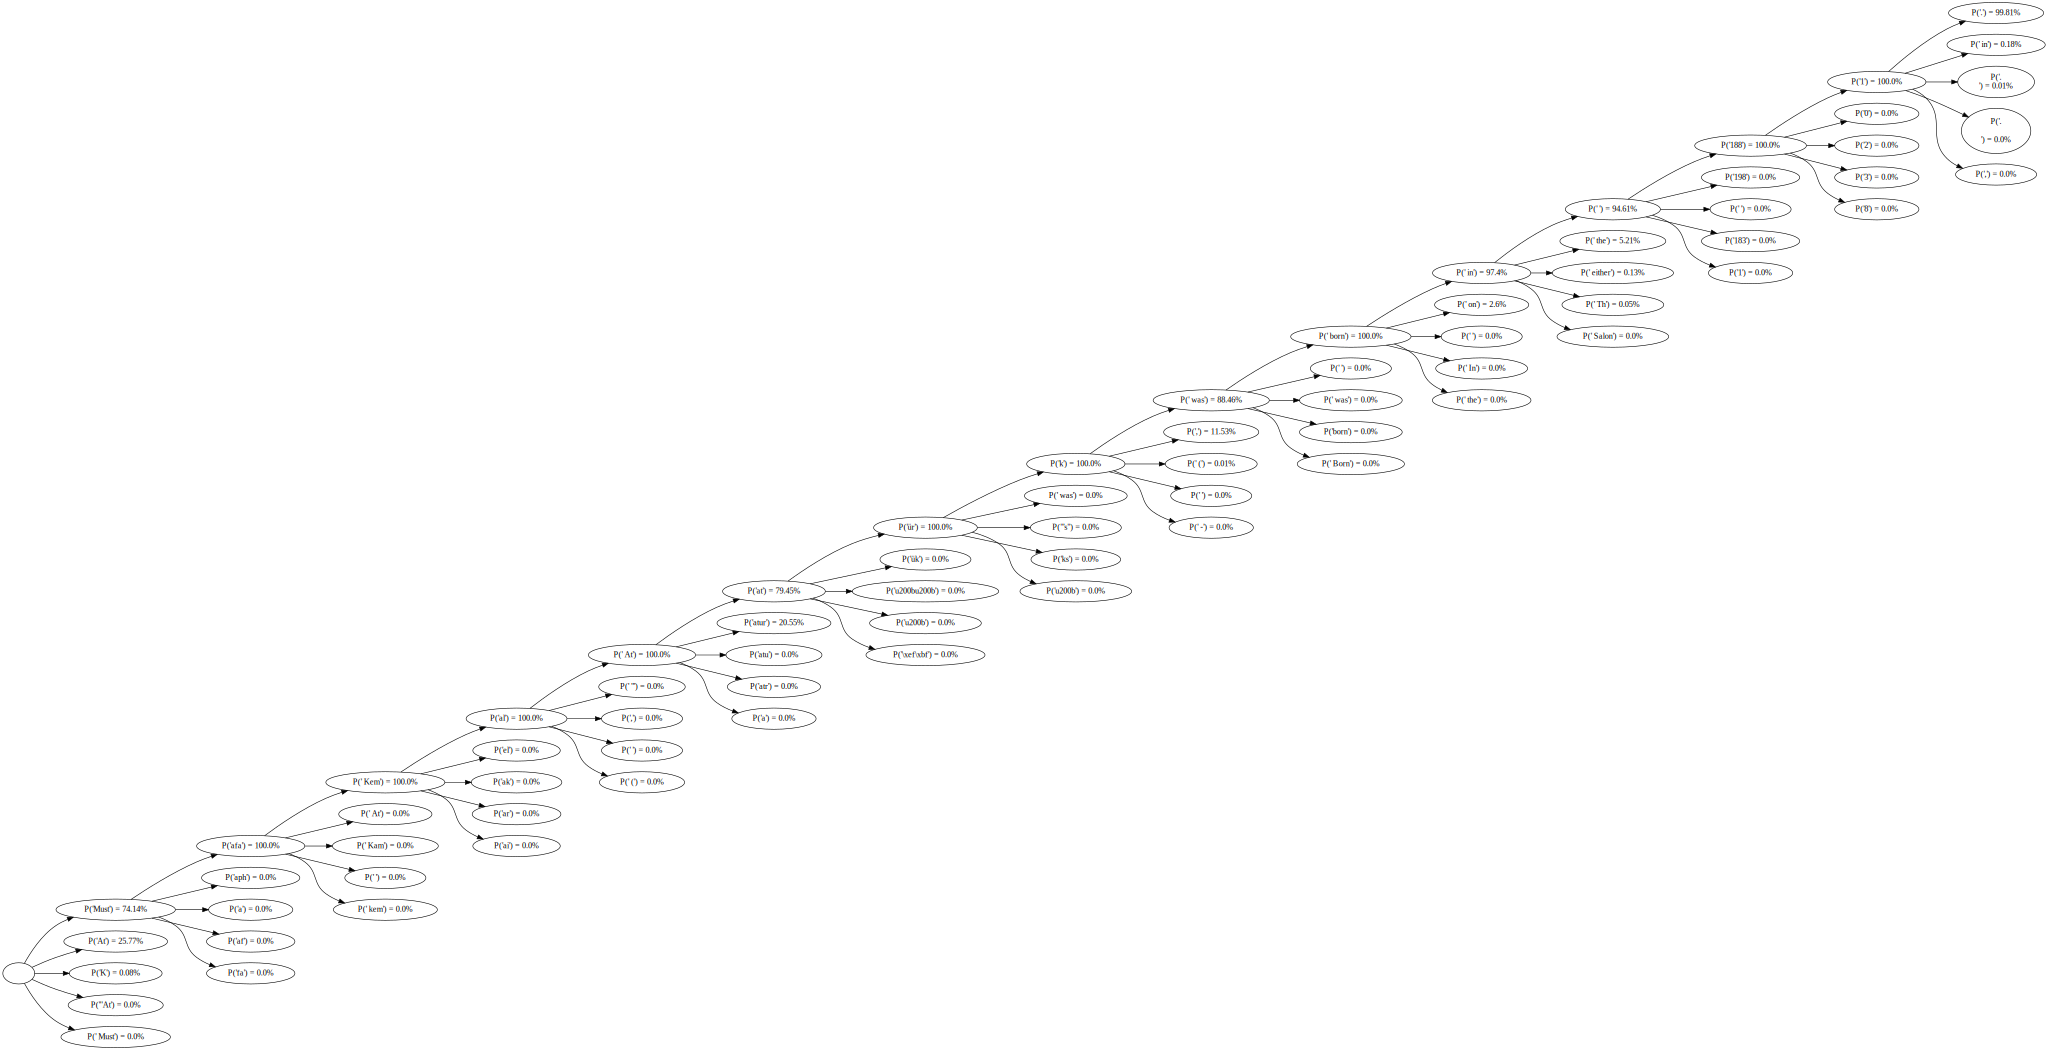

In [6]:
# Try the function with a simple question
question = "What year was Ataturk born? Answer in one sentence."
result, graph = get_response_with_confidence(question, verbose=False)
graph.render("ataturk")
graph

## Hard to make models hallucinate

As models get better, harder and harder to make them hallucinate on simple questions and publicly known data.
But doesn't mean that it won't happen in more niche cases or on your data.


Confidence Analysis:
Average confidence: 90.57%
Minimum confidence: 55.84%
Maximum confidence: 100.00%

Question: Who is Clara Schumann? Answer in one sentence.
Response: Clara Schumann was a renowned German pianist and composer of the Romantic era, known for her virtuosic piano performances and compositions.
Confidence Score: 80.15%


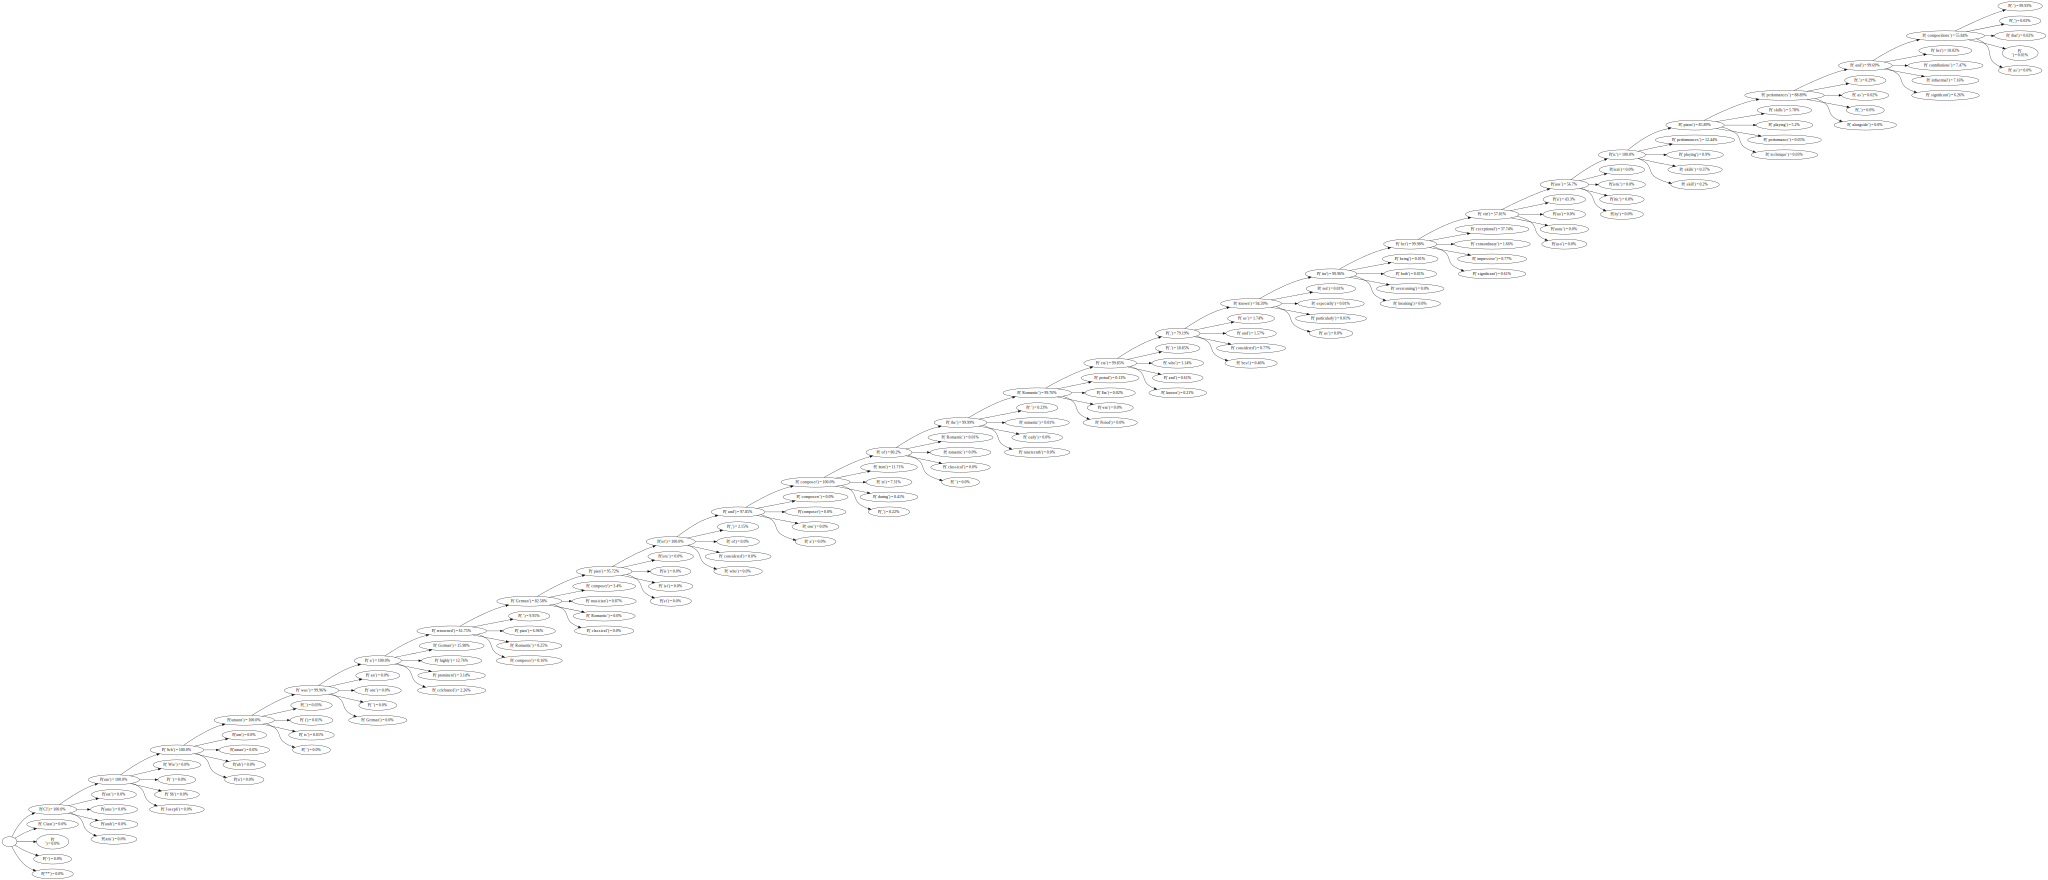

In [7]:
# Try the function with a simple question
question = "Who is Clara Schumann? Answer in one sentence."
result, graph = get_response_with_confidence(question, verbose=False)
graph.render("clara")
graph


Confidence Analysis:
Average confidence: 79.30%
Minimum confidence: 34.37%
Maximum confidence: 100.00%

Tokens with unusually low confidence:
Token: 'The', Confidence: 36.08%
Token: ' Office', Confidence: 35.19%
Token: ' Ed', Confidence: 34.37%

Question: Who is John Cole Howard? Answer in one sentence.
Response: John Cole Howard is a fictional character from the TV show "The Office," portrayed by actor Ed Helms.
Confidence Score: 65.82%


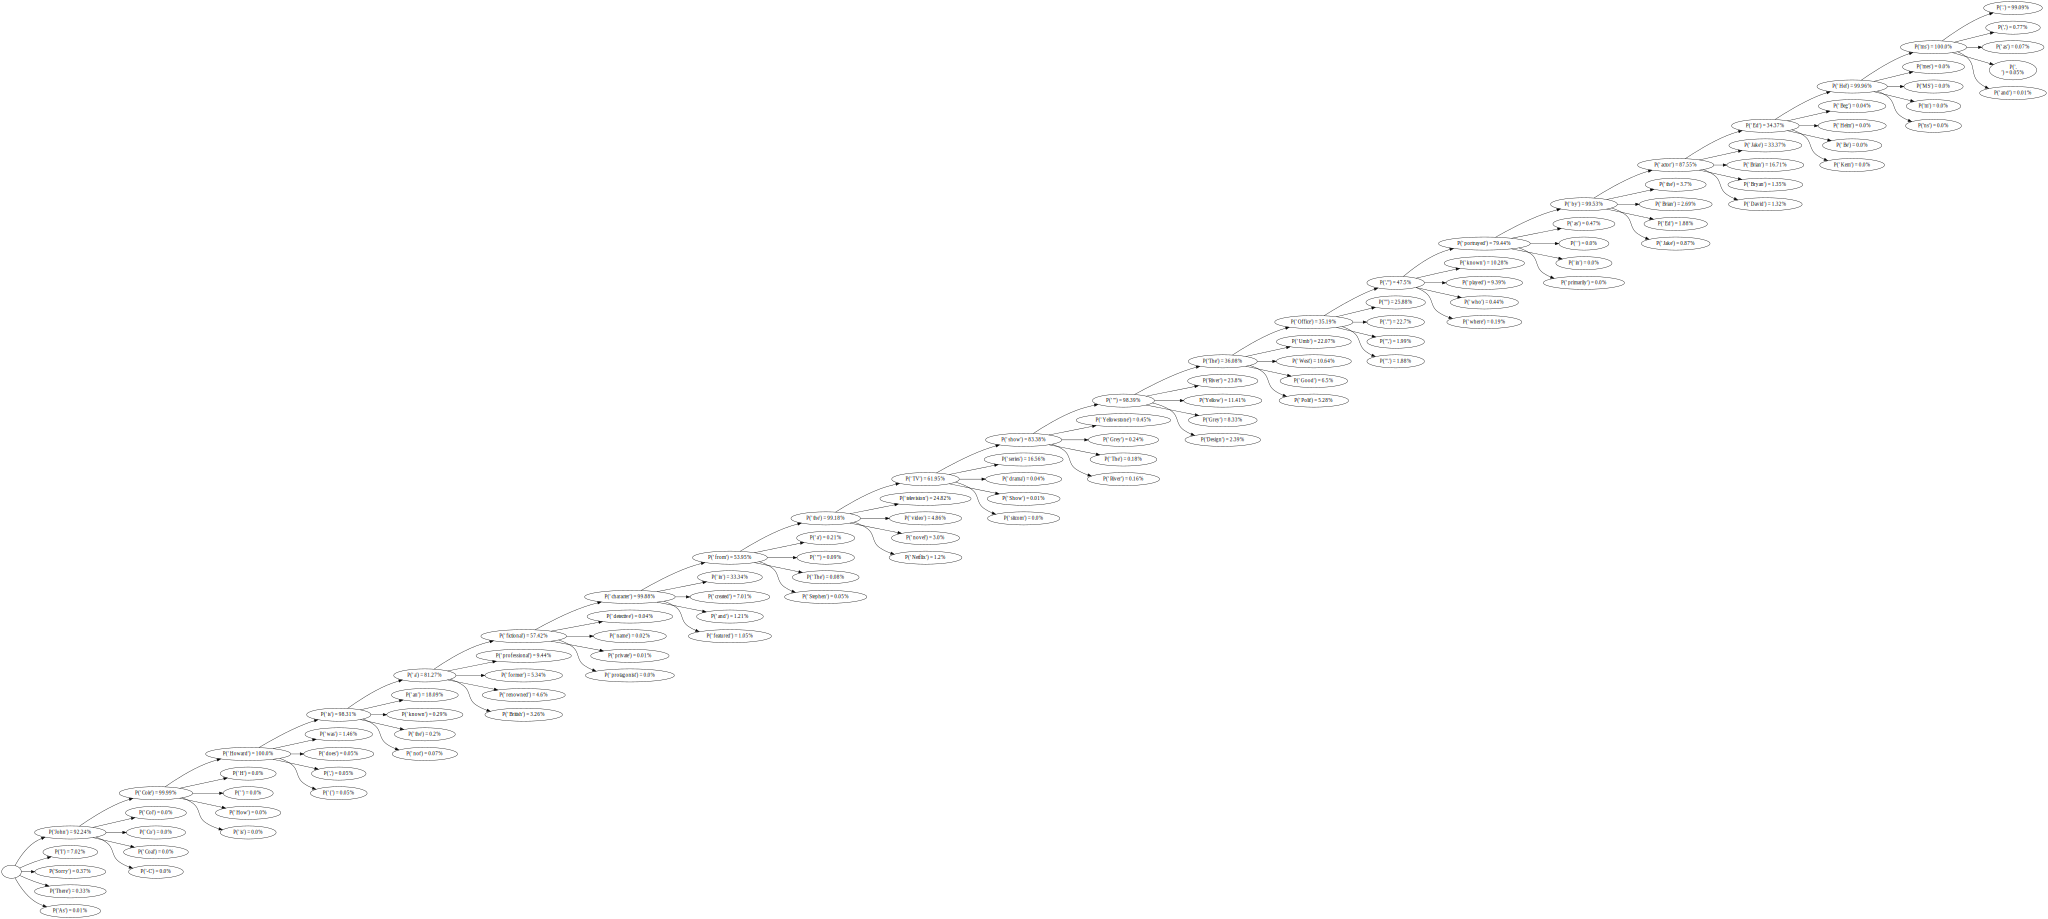

In [8]:
question = "Who is John Cole Howard? Answer in one sentence."
result, graph = get_response_with_confidence(question, verbose=False)
graph.render("theoffice")
graph

Ed Helmes character is Andy Bernard, not John Cole Howard. The low confidence score on the show's name could be due to the fact that the model is not sure about the answer.

In [10]:
# Try the function with a question where the model hallucinates
question = "What was the exact time and temperature when Marie Curie made her first radium discovery? Include the barometric pressure in the lab."
result, graph = get_response_with_confidence(question, verbose=False)


Confidence Analysis:
Average confidence: 83.06%
Minimum confidence: 18.95%
Maximum confidence: 100.00%

Tokens with unusually low confidence:
Token: ' documented', Confidence: 18.95%
Token: ' it', Confidence: 36.49%
Token: ' was', Confidence: 35.10%
Token: ' extensive', Confidence: 32.88%

Question: What was the exact time and temperature when Marie Curie made her first radium discovery? Include the barometric pressure in the lab.
Response: Marie Curie made her first radium discovery in 1898. Unfortunately, the exact time, temperature, and barometric pressure in the lab at that moment are not documented or widely known. However, it is known that her groundbreaking discovery of radium was a result of her extensive research and experimentation in the field of radioactivity.
Confidence Score: 63.83%


'mariecurie.png'

Hard to make the models hallucinate on this one.

In [11]:
# Try the function with a question where the model hallucinates
question = "Describe the collaboration between Nikola Tesla and Thomas Edison on their joint patent for wireless energy transmission in 1891. What were the specific technical details?"
result, graph = get_response_with_confidence(question, verbose=False)


Confidence Analysis:
Average confidence: 84.56%
Minimum confidence: 23.95%
Maximum confidence: 100.00%

Tokens with unusually low confidence:
Token: ' during', Confidence: 32.62%
Token: ' philosoph', Confidence: 39.41%
Token: ' electricity', Confidence: 25.18%
Token: 'Tesla', Confidence: 27.78%
Token: ' systems', Confidence: 32.26%
Token: ' Their', Confidence: 26.14%
Token: ' differing', Confidence: 37.73%
Token: ' where', Confidence: 37.70%
Token: ' later', Confidence: 23.95%
Token: ' this', Confidence: 35.60%
Token: ' separate', Confidence: 38.59%
Token: ' more', Confidence: 34.86%

Question: Describe the collaboration between Nikola Tesla and Thomas Edison on their joint patent for wireless energy transmission in 1891. What were the specific technical details?
Response: I'm sorry, but there seems to be a misunderstanding. Nikola Tesla and Thomas Edison were actually rivals in the field of electrical engineering during the late 19th century. They had different approaches and philoso

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.553459 to fit


'tesla_edison.png'